# Necessary Libraries and Modules

In [150]:
import numpy as np

import pickle
import os
import time

from sklearn.datasets import make_circles, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [85]:
class Layer:
    def __init__(self, input_size, output_size, activation='relu'):
        self.input_size = input_size
        self.output_size = output_size
        self.activation_name = activation
        
        # Weight initialization
        self.weights = np.random.randn(output_size, input_size) * np.sqrt(2. / input_size)
        self.biases = np.zeros((output_size, 1))
        
    def get_params(self):
        return self.weights.size + self.biases.size

In [101]:
class NN:
    def __init__(self, learning_rate=0.01, epochs=100):
        self.layers = []
        self.lr = learning_rate
        self.epochs = epochs
        
    def add(self, layer):
        self.layers.append(layer)
    
    def _get_activation(self, name):
        def linear(x, derivative=False):
            return 1 if derivative else x
        
        def relu(x, derivative=False):
            return np.where(x > 0, 1, 0) if derivative else np.maximum(0, x)
        
        def tanh(x, derivative=False):
            return np.tanh(x) if not derivative else 1 - np.tanh(x)**2
        
        def leaky_relu(x, alpha=0.01, derivative=False):
            return np.where(x >= 0, x, alpha * x) if not derivative else np.where(x >= 0, 1, alpha)
                
        def sigmoid(x, derivative=False):
            clipped_x = np.clip(x, -500, 500)
            if derivative:
                sigmoid_x = 1 / (1 + np.exp(-clipped_x))
                return sigmoid_x * (1 - sigmoid_x)
            return 1 / (1 + np.exp(-clipped_x))
        
        def softmax(x, derivative=False):
            if derivative:
                return x * (1 - x)
            exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
            return exp_x / np.sum(exp_x, axis=0, keepdims=True)
        
        match name.lower():
            case 'linear': return linear
            case 'relu': return relu
            case 'tanh': return tanh
            case 'leaky_relu': return leaky_relu
            case 'sigmoid': return sigmoid
            case 'softmax': return softmax
            case _: return linear
            
    def summary(self):
        print("Model Summary:")
        print("---------------")
        total_params = 0
        print(f"{'Layer (type)':<20}{'Output Shape':<20}{'Param #':<10}")
        print("="*50)
        
        for i, layer in enumerate(self.layers):
            print(f"{f'Layer {i}':<20}{f'({layer.output_size},)':<20}{layer.get_params():<10}")
            total_params += layer.get_params()
        
        print("="*50)
        print(f"Total params: {total_params}")
    
    def forward_pass(self, X):
        activations = [X]
        z_values = []
        
        for i, layer in enumerate(self.layers):
            z = np.dot(layer.weights, activations[-1]) + layer.biases
            z_values.append(z)
            
            # Determine activation for last layer
            if i < len(self.layers) - 1:
                a = self._get_activation(layer.activation_name)(z)
            else:
                # Use last layer's specified activation
                a = self._get_activation(layer.activation_name)(z)
            
            activations.append(a)
        
        return activations, z_values
    
    def backward_pass(self, X, y, activations, z_values):
        m = X.shape[1]
        dW = []
        db = []
        
        # Prepare labels based on last layer activation
        last_activation = self.layers[-1].activation_name
        if last_activation == 'softmax':
            y_encoded = np.zeros_like(activations[-1])
            for i in range(m):
                y_encoded[y[i], i] = 1
            dZ = activations[-1] - y_encoded
        else:  # sigmoid (binary classification)
            dZ = activations[-1] - y.reshape(1, -1)
        
        for i in range(len(self.layers) - 1, -1, -1):
            # Compute gradients
            dW.insert(0, np.dot(dZ, activations[i].T) / m)
            db.insert(0, np.sum(dZ, axis=1, keepdims=True) / m)
            
            # Compute gradient for next layer if not input layer
            if i > 0:
                activation_derivative = self._get_activation(self.layers[i-1].activation_name)
                dZ = np.dot(self.layers[i].weights.T, dZ) * activation_derivative(z_values[i-1], derivative=True)
        
        return dW, db
    
    def train(self, X, y, verbose=False, freq=100):
        freq = max(freq, 1)
        losses = []
        last_activation = self.layers[-1].activation_name
        start = time.time()
        
        for epoch in range(self.epochs):
            # Forward pass
            activations, z_values = self.forward_pass(X)
            
            # Compute loss based on last layer activation
            if last_activation == 'softmax':
                y_encoded = np.zeros_like(activations[-1])
                for i in range(X.shape[1]):
                    y_encoded[y[i], i] = 1
                loss = -np.sum(y_encoded * np.log(activations[-1] + 1e-15)) / X.shape[1]
            else:  # sigmoid (binary cross-entropy)
                loss = -np.mean(y * np.log(activations[-1] + 1e-15) + 
                                (1 - y) * np.log(1 - activations[-1] + 1e-15))
            
            losses.append(loss)
            
            # Backward pass
            dW, db = self.backward_pass(X, y, activations, z_values)
            
            # Update parameters
            for i in range(len(self.layers)):
                self.layers[i].weights -= self.lr * dW[i]
                self.layers[i].biases -= self.lr * db[i]
            
            # Print loss periodically
            if verbose or epoch % freq == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}, Time: {time.time()-start:.2f}")
                start = time.time()
        
        return losses
    
    def predict(self, X):
        activations, _ = self.forward_pass(X)
        last_activation = self.layers[-1].activation_name
        
        if last_activation == 'softmax':
            return np.argmax(activations[-1], axis=0)
        else:  # sigmoid
            return (activations[-1] > 0.5).astype(int)
        
    def save_model(self, filepath):
        model_data = {
            'layers': [(layer.input_size, layer.output_size, layer.activation_name) for layer in self.layers],
            'weights': [layer.weights for layer in self.layers],
            'biases': [layer.biases for layer in self.layers],
            'learning_rate': self.lr,
            'epochs': self.epochs
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath):
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Model file {filepath} not found")
        
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        # Reset layers and reconstruct network
        self.layers = []
        for input_size, output_size, activation_name in model_data['layers']:
            layer = Layer(input_size, output_size, activation_name)
            self.layers.append(layer)
        
        # Restore weights and biases
        for i, (layer, weights, biases) in enumerate(zip(self.layers, model_data['weights'], model_data['biases'])):
            layer.weights = weights
            layer.biases = biases
        
        # Restore other parameters
        self.lr = model_data['learning_rate']
        self.epochs = model_data['epochs']
        
        print(f"Model loaded from {filepath}")
        return self

In [102]:
def plot_decision_boundary(predict_func, X, y):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Prepare input for prediction
    X_mesh = np.column_stack((xx.ravel(), yy.ravel())).T
    
    Z = predict_func(X_mesh)
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    plt.scatter(X[0, :], X[1, :], c=y.ravel(), cmap=plt.cm.RdYlBu, s=10, edgecolor='k')

# Genreate linear dataset

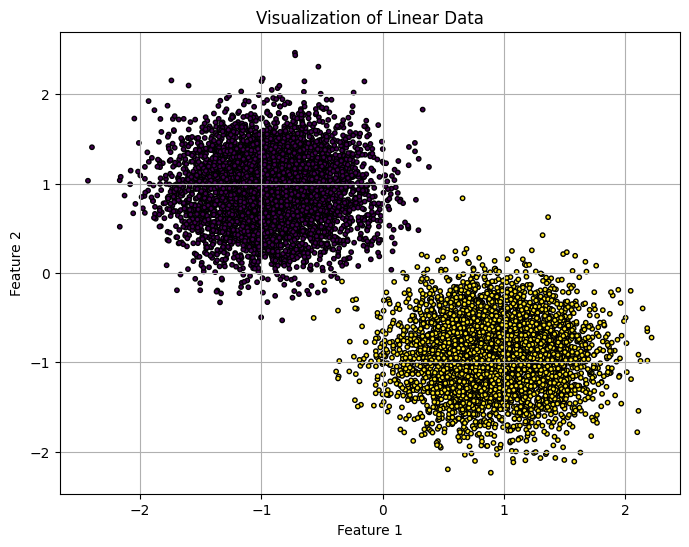

In [152]:
# Generate and preprocess linear data
X, y = make_blobs(n_samples=10000, centers=2, cluster_std=1.5, random_state=42)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=10, edgecolor='k')
plt.title('Visualization of Linear Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)

# Generate non-linear dataset

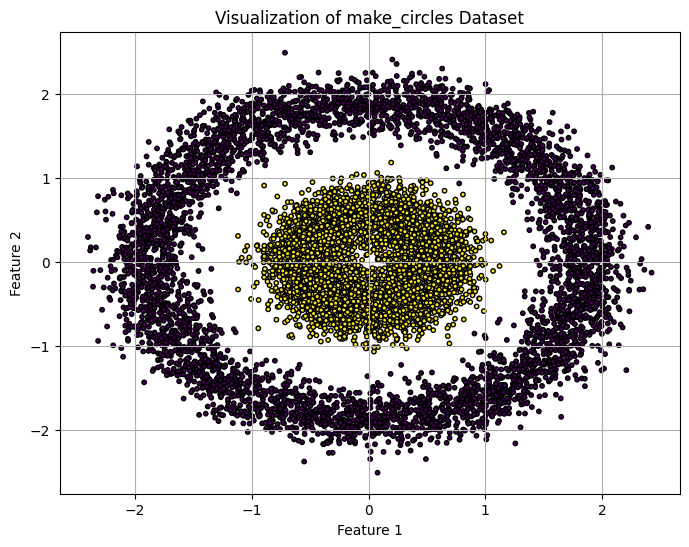

In [151]:
# Generate and preprocess dataset
X, y = make_circles(n_samples=10000, noise=0.1, factor=0.3)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=10, edgecolor='k')
plt.title('Visualization of make_circles Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)

In [140]:
# Reshape for neural network
X_train = X_train.T
X_test = X_test.T
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)

In [141]:
# Create and train neural network
print("\nTraining Neural Network:")
model = NN(learning_rate=0.01, epochs=500)
model.add(Layer(input_size=2, output_size=16, activation='relu'))
model.add(Layer(input_size=16, output_size=8, activation='relu'))
model.add(Layer(input_size=8, output_size=1, activation='sigmoid'))

# Print model summary
model.summary()


Training Neural Network:
Model Summary:
---------------
Layer (type)        Output Shape        Param #   
Layer 0             (16,)               48        
Layer 1             (8,)                136       
Layer 2             (1,)                9         
Total params: 193


In [142]:
# Train the model
losses = model.train(X_train, y_train)

Epoch 0, Loss: 1.1748, Time: 0.01
Epoch 100, Loss: 0.6163, Time: 0.35
Epoch 200, Loss: 0.5346, Time: 0.21
Epoch 300, Loss: 0.4731, Time: 0.19
Epoch 400, Loss: 0.4184, Time: 0.20



Test Accuracy: 55.00%


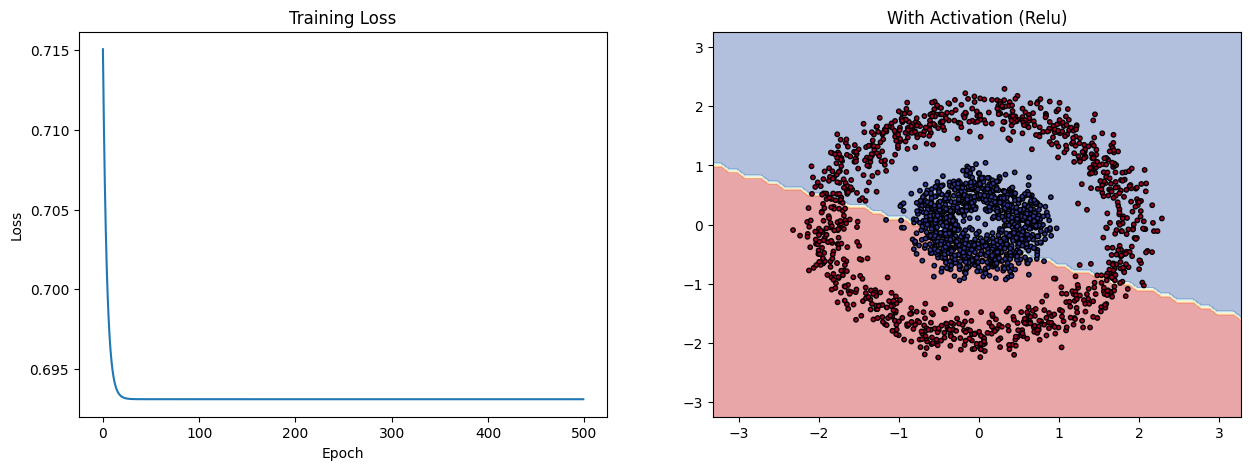

In [149]:
# Plot results
plt.figure(figsize=(15, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot decision boundaries
plt.subplot(1, 2, 2)
plot_decision_boundary(lambda x: model.predict(x), X_test, y_test)
plt.title('With Activation (Relu)')

# Evaluate model
predictions = model.predict(X_test)
accuracy = np.mean(predictions == y_test)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

In [144]:
model.save_model('./results/models/circlular_relu')

Model saved to ./models/nonlinear_relu


In [145]:
print("\nTraining Neural Network without activation:")
model = NN(learning_rate=0.01, epochs=500)
model.add(Layer(input_size=2, output_size=16, activation='linear'))
model.add(Layer(input_size=16, output_size=8, activation='linear'))
model.add(Layer(input_size=8, output_size=1, activation='sigmoid'))

# Print model summary
model.summary()


Training Neural Network without activation:
Model Summary:
---------------
Layer (type)        Output Shape        Param #   
Layer 0             (16,)               48        
Layer 1             (8,)                136       
Layer 2             (1,)                9         
Total params: 193


In [146]:
# Train the model
losses = model.train(X_train, y_train)

Epoch 0, Loss: 0.7151, Time: 0.01
Epoch 100, Loss: 0.6931, Time: 0.19
Epoch 200, Loss: 0.6931, Time: 0.16
Epoch 300, Loss: 0.6931, Time: 0.15
Epoch 400, Loss: 0.6931, Time: 0.16


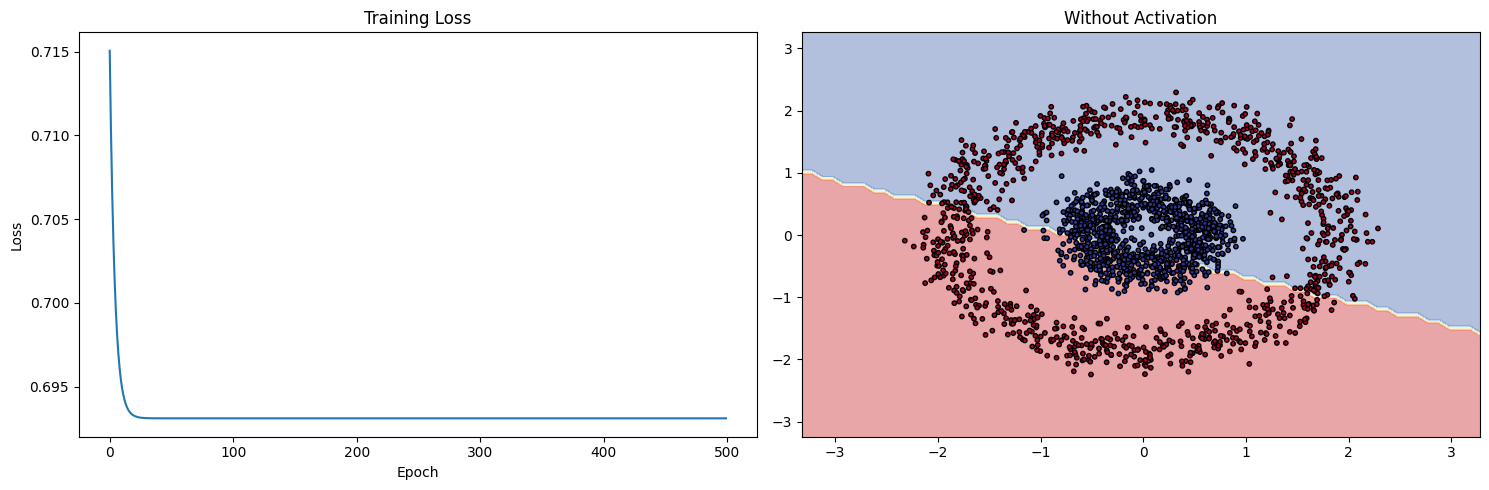


Test Accuracy: 55.00%


In [147]:
# Plot results
plt.figure(figsize=(15, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot decision boundaries
plt.subplot(1, 2, 2)
plot_decision_boundary(lambda x: model.predict(x), X_test, y_test)
plt.title('Without Activation')

plt.tight_layout()
plt.show()

# Evaluate model
predictions = model.predict(X_test)
accuracy = np.mean(predictions == y_test)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

In [148]:
model.save_model('./results/models/circular_without_relu')

Model saved to ./models/nonlinear_without_relu
